In [1]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from loader import get_train_loader
import time

In [2]:
from networks import *

In [3]:
autoencoder_people_4 = torch.load('autoencoder.people.4.pt')
autoencoder_stickmans_4 = torch.load('autoencoder.stickmen.4.pt')
autoencoder_people_8 = torch.load('autoencoder.people.8.pt')
autoencoder_stickmans_8 = torch.load('autoencoder.stickmen.8.pt')

In [6]:
batch_size = 64
mask4_group_1 = np.zeros((batch_size, 3, 8, 8)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(8):
            for j in range(8):
                if i % 2 == 0 and j % 2 == 0:
                    mask4_group_1[m][n][i][j] = True

mask4_group_2 = np.zeros((batch_size, 3, 8, 8)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(8):
            for j in range(8):
                if i % 2 == 0 and j % 2 == 1:
                    mask4_group_2[m][n][i][j] = True

mask4_group_3 = np.zeros((batch_size, 3, 8, 8)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(8):
            for j in range(8):
                if i % 2 == 1 and j % 2 == 0:
                    mask4_group_3[m][n][i][j] = True

mask4_group_4 = np.zeros((batch_size, 3, 8, 8)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(8):
            for j in range(8):
                if i % 2 == 1 and j % 2 == 1:
                    mask4_group_4[m][n][i][j] = True

In [41]:
net4_group2 = torch.load("net4.group2.pt")
net4_group3 = torch.load("net4.group3.pt")
net4_group4 = torch.load("net4.group4.pt")

In [8]:
def convert_input_into_image_4(X_batch_input_initial, y_batch_output, is_plot=False):
    X_batch_input = X_batch_input_initial.clone()
    X_batch_input = X_batch_input[mask4_group_1.nonzero()].view((batch_size, 3, 4, 4))
    X_batch_input = Variable(X_batch_input).cuda()
    
    group_1 = X_batch_input.clone()
    group_2 = net4_group2(X_batch_input,
                 keypoints=autoencoder_stickmans_4(Variable(y_batch_output).cuda())[1],
                 embeddings=autoencoder_people_4(Variable(X_batch_input_initial).cuda())[1]).cpu().data
    
    X_batch_input = X_batch_input_initial.clone()
    X_batch_input = X_batch_input[(mask4_group_1 + mask4_group_2).nonzero()].view((batch_size, 3, 4, 8))
    X_batch_input = Variable(X_batch_input).cuda()
    
    group_3 = net4_group3(X_batch_input,
                 keypoints=autoencoder_stickmans_4(Variable(y_batch_output).cuda())[1],
                 embeddings=autoencoder_people_4(Variable(X_batch_input_initial).cuda())[1]).cpu().data
    
    X_batch_input = X_batch_input_initial.clone()
    X_batch_input[(mask4_group_4).nonzero()] = 0
    X_batch_input = Variable(X_batch_input).cuda()
    
    group_4 = net4_group4(X_batch_input,
                 keypoints=autoencoder_stickmans_4(Variable(y_batch_output).cuda())[1],
                 embeddings=autoencoder_people_4(Variable(X_batch_input_initial).cuda())[1]).cpu().data
    
    final_image = torch.zeros_like(X_batch_input).cpu().data.float()
    final_image[mask4_group_1.nonzero()] = group_1.view(-1).cpu().data.float()
    final_image[mask4_group_2.nonzero()] = group_2.view(-1).float()
    final_image[mask4_group_3.nonzero()] = group_3.view(-1).float()
    final_image[mask4_group_4.nonzero()] = group_4.view(-1).float()
#     if is_plot:
#         plot_gallery(X_batch[:, 1], 8, 8, 1, 3)
#         plot_gallery(final_image, 8, 8, 1, 3)
    return final_image

In [9]:
dim_x = 16
batch_size = 64
train_loader, val_loader = get_train_loader("../deepfashion/index.p", batch_size=batch_size, resize_size=dim_x)

In [10]:
class Net8Group2(nn.Module):
    """
        Network for predictions group 2 images based on group 1.
        input size: 4x4
        output size: 4x4
    """

    def __init__(self, layers=[1], bottelneck_size=32):
        super(Net8Group2, self).__init__()
        
        self.first_part = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(inplace=True)
        )

        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(96, 64, 2, stride=2)
        )

        self.conv_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=1),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=(2, 2), stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, keypoints, embeddings):
        x = self.first_part(x)
        x = torch.cat((x, keypoints, embeddings), dim=1)
        x = self.up_1(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        return x

In [11]:
mask_input_1 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 ==0:
                    mask_input_1[m][n][i][j] = True

In [12]:
mask_output_1 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 == 1:
                    mask_output_1[m][n][i][j] = True

In [310]:
criterion = torch.nn.MSELoss()
net8_group2 = Net8Group2().cuda()
optimizer = optim.Adam(net8_group2.parameters(), lr=1e-3)

In [311]:
def train_network(net, criterion, optimizer, mask_input, mask_output, shape_input, shape_output, num_epochs):
    train_loss = []
    val_loss = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        net.train(True)
        i = 0
        for X_batch, y_batch in train_loader:
            i += 1
            if X_batch.shape[0] != batch_size:
                continue
            X_batch_input = X_batch[:, 0]
            X_batch_input = X_batch_input[mask_input.nonzero()].view(shape_input)
            
            y_batch_output = y_batch[:, 1]
            y_batch_output = y_batch_output[mask_input.nonzero()].view(shape_input)
            
            X_batch_input = Variable(convert_input_into_image_4(X_batch_input, y_batch_output)).cuda()

            X_batch_output = X_batch[:, 1]
            X_batch_output = X_batch_output[mask_output.nonzero()].view(shape_output)
            X_batch_output = Variable(X_batch_output).cuda()

            output_img = net(X_batch_input,
                                     keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                                     embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1])
            loss = criterion(output_img, X_batch_output)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.cpu().data.numpy()[0])

        # And a full pass over the validation data:
    #     autoencoder.train(False) # disable dropout / use averages for batch_norm
    #     for X_batch, y_batch in val_loader:
    #         X_batch_0 = Variable(y_batch[:, 0]).cuda()
    #         output_img, _ = autoencoder(X_batch_0)
    #         val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
    #         X_batch_1 = Variable(y_batch[:, 1]).cuda()
    #         output_img, _ = autoencoder(X_batch_1)
    #         val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])

        print 
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-2 * len(train_loader):])))
    #     print("  validation loss: \t\t\t{:.6f}".format(
    #         np.mean(val_loss[-2 * len(val_loader):])))

In [ ]:
train_network(net8_group2, criterion, optimizer, mask_input_1, mask_output_1,
              shape_input=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=100
             )

Epoch 1 of 100 took 50.293s
  training loss (in-iteration): 	0.007564
Epoch 2 of 100 took 50.150s
  training loss (in-iteration): 	0.007507
Epoch 3 of 100 took 50.864s
  training loss (in-iteration): 	0.007380
Epoch 4 of 100 took 52.429s
  training loss (in-iteration): 	0.007247
Epoch 5 of 100 took 50.950s
  training loss (in-iteration): 	0.007148
Epoch 6 of 100 took 49.872s
  training loss (in-iteration): 	0.007073
Epoch 7 of 100 took 49.489s
  training loss (in-iteration): 	0.006967
Epoch 8 of 100 took 50.476s
  training loss (in-iteration): 	0.006823
Epoch 9 of 100 took 50.571s
  training loss (in-iteration): 	0.006686
Epoch 10 of 100 took 50.592s
  training loss (in-iteration): 	0.006595
Epoch 11 of 100 took 49.508s
  training loss (in-iteration): 	0.006529
Epoch 12 of 100 took 49.726s
  training loss (in-iteration): 	0.006451
Epoch 13 of 100 took 52.540s
  training loss (in-iteration): 	0.006376
Epoch 14 of 100 took 52.504s
  training loss (in-iteration): 	0.006327
Epoch 15 of 100

In [ ]:
train_network(net8_group2, criterion, optimizer, mask_input_1, mask_output_1,
              shape_input=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=100
             )

Epoch 1 of 100 took 51.714s
  training loss (in-iteration): 	0.003558
Epoch 2 of 100 took 50.972s
  training loss (in-iteration): 	0.003554
Epoch 3 of 100 took 50.798s
  training loss (in-iteration): 	0.003547
Epoch 4 of 100 took 50.803s
  training loss (in-iteration): 	0.003521
Epoch 5 of 100 took 52.934s
  training loss (in-iteration): 	0.003478
Epoch 6 of 100 took 53.156s
  training loss (in-iteration): 	0.003450
Epoch 7 of 100 took 51.263s
  training loss (in-iteration): 	0.003454
Epoch 8 of 100 took 51.995s
  training loss (in-iteration): 	0.003462
Epoch 9 of 100 took 51.524s
  training loss (in-iteration): 	0.003443
Epoch 10 of 100 took 51.417s
  training loss (in-iteration): 	0.003426
Epoch 11 of 100 took 57.189s
  training loss (in-iteration): 	0.003412
Epoch 12 of 100 took 57.506s
  training loss (in-iteration): 	0.003410
Epoch 13 of 100 took 60.399s
  training loss (in-iteration): 	0.003422
Epoch 14 of 100 took 63.957s
  training loss (in-iteration): 	0.003419
Epoch 15 of 100

In [335]:
torch.save(net8_group2, "net8.group2.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net8Group2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
net8_group2 = torch.load("net8.group2.pt")

In [24]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    scale_const = 1.2
    plt.figure(figsize=(3 / scale_const * n_col, 3.4 / scale_const * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].numpy().transpose(1,2,0), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [424]:
for X_batch, y_batch in train_loader:
    break

In [330]:
X_batch_input = X_batch[:, 0]
X_batch_input = X_batch_input[mask_input_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))
X_batch_input = Variable(X_batch_input).cuda()

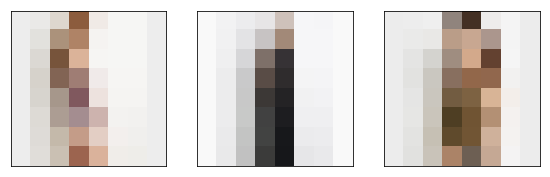

In [331]:
plot_gallery(X_batch_input.cpu().data, 8, 8, 1, 3)

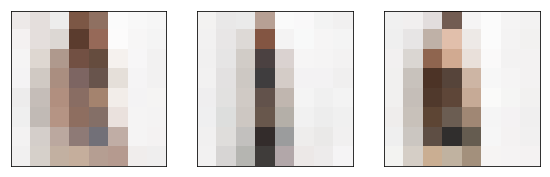

In [332]:
X_batch_input = X_batch[:, 0]
X_batch_input = X_batch_input[mask_input_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))

y_batch_output = y_batch[:, 1]
y_batch_output = y_batch_output[mask_input_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))

X_batch_input = Variable(convert_input_into_image_4(X_batch_input, y_batch_output)).cuda()

X_batch_output = X_batch[:, 1]
X_batch_output = X_batch_output[mask_output_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))
X_batch_output = Variable(X_batch_output).cuda()
plot_gallery(net8_group2(X_batch_input,
                 keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1]).cpu().data,
             8, 8, 1, 3)

In [333]:
X_batch_output = X_batch[:, 1]
X_batch_output = X_batch_output[mask_output_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))

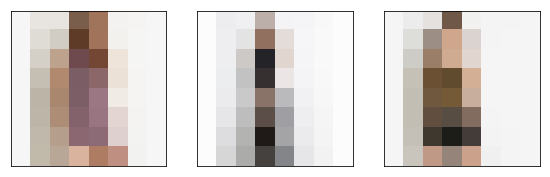

In [334]:
plot_gallery(X_batch_output, 8, 8, 1, 3)

In [13]:
class Net8Group3(nn.Module):
    """
        Network for predictions group 2 images based on group 1.
        input size: 4x4
        output size: 4x4
    """

    def __init__(self, layers=[1], bottelneck_size=32):
        super(Net8Group3, self).__init__()
        
        self.first_part = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(1, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(1, 3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(96, 64, 2, stride=2)
        )

        self.conv_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=1),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=(2, 2), stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, keypoints, embeddings):
        x = self.first_part(x)
#         print(x.shape)
        x = torch.cat((x, keypoints, embeddings), dim=1)
        x = self.up_1(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        return x

In [14]:
def train_network_group_3(net, criterion, optimizer, mask_input, mask_output, shape_input, shape_output, num_epochs):
    train_loss = []
    val_loss = []
    
    mask_first_part = np.zeros((batch_size, 3, int(dim_x / 2), dim_x)).astype(bool)
    for m in range(batch_size):
        for n in range(3):
            for i in range(int(dim_x/2)):
                for j in range(dim_x):
                    if j % 2 == 0:
                        mask_first_part[m][n][i][j] = True
    mask_second_part = np.zeros((batch_size, 3, int(dim_x / 2), dim_x)).astype(bool)
    for m in range(batch_size):
        for n in range(3):
            for i in range(int(dim_x/2)):
                for j in range(dim_x):
                    if j % 2 == 1:
                        mask_second_part[m][n][i][j] = True
    
    for epoch in range(num_epochs):
        start_time = time.time()
        net.train(True)
        i = 0
        for X_batch, y_batch in train_loader:
            i += 1
            if X_batch.shape[0] != batch_size:
                continue
            X_batch_input = X_batch[:, 0]
            X_batch_input = X_batch_input[mask_input.nonzero()].view(shape_output)
            
            y_batch_output = y_batch[:, 1]
            y_batch_output = y_batch_output[mask_input.nonzero()].view(shape_output)
            
            X_batch_input = Variable(convert_input_into_image_4(X_batch_input, y_batch_output)).cuda()
            X_batch_group_2 = net8_group2(X_batch_input,
                 keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1])
#             print(X_batch_input.shape)
#             print(X_batch_group_2.shape)
            X_cur_input = Variable(torch.zeros(shape_input)).cuda().float()
            X_cur_input[mask_first_part.nonzero()] = X_batch_input.view(-1).float()
            X_cur_input[mask_second_part.nonzero()] = X_batch_group_2.view(-1).float()
#             print(X_cur_input.shape)
            X_batch_output = X_batch[:, 1]
            X_batch_output = X_batch_output[mask_output.nonzero()].view(shape_output)
            X_batch_output = Variable(X_batch_output).cuda()

            output_img = net(X_cur_input,
                                     keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                                     embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1])
            loss = criterion(output_img, X_batch_output)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.cpu().data.numpy()[0])

        # And a full pass over the validation data:
    #     autoencoder.train(False) # disable dropout / use averages for batch_norm
    #     for X_batch, y_batch in val_loader:
    #         X_batch_0 = Variable(y_batch[:, 0]).cuda()
    #         output_img, _ = autoencoder(X_batch_0)
    #         val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
    #         X_batch_1 = Variable(y_batch[:, 1]).cuda()
    #         output_img, _ = autoencoder(X_batch_1)
    #         val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])

        print 
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-2 * len(train_loader):])))
    #     print("  validation loss: \t\t\t{:.6f}".format(
    #         np.mean(val_loss[-2 * len(val_loader):])))

In [396]:
# mask_input_2 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
# for m in range(batch_size):
#     for n in range(3):
#         for i in range(dim_x):
#             for j in range(dim_x):
#                 if i % 2 == 0:
#                     mask_input_2[m][n][i][j] = True

In [17]:
mask_output_2 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 0:
                    mask_output_2[m][n][i][j] = True

In [18]:
criterion = torch.nn.MSELoss()
net8_group3 = Net8Group3().cuda()
optimizer = optim.Adam(net8_group3.parameters(), lr=1e-3)

In [19]:
train_network_group_3(net8_group3, criterion, optimizer, mask_input_1, mask_output_2,
              shape_input=(batch_size, 3, int(dim_x / 2), int(dim_x)),
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=100
             )

Epoch 1 of 100 took 51.245s
  training loss (in-iteration): 	0.022289
Epoch 2 of 100 took 49.976s
  training loss (in-iteration): 	0.015648
Epoch 3 of 100 took 49.572s
  training loss (in-iteration): 	0.008548
Epoch 4 of 100 took 51.880s
  training loss (in-iteration): 	0.007852
Epoch 5 of 100 took 52.138s
  training loss (in-iteration): 	0.007489
Epoch 6 of 100 took 56.786s
  training loss (in-iteration): 	0.007235
Epoch 7 of 100 took 53.878s
  training loss (in-iteration): 	0.007012
Epoch 8 of 100 took 60.878s
  training loss (in-iteration): 	0.006830
Epoch 9 of 100 took 55.050s
  training loss (in-iteration): 	0.006679
Epoch 10 of 100 took 49.213s
  training loss (in-iteration): 	0.006535
Epoch 11 of 100 took 51.549s
  training loss (in-iteration): 	0.006414
Epoch 12 of 100 took 52.666s
  training loss (in-iteration): 	0.006313
Epoch 13 of 100 took 50.548s
  training loss (in-iteration): 	0.006206
Epoch 14 of 100 took 50.047s
  training loss (in-iteration): 	0.006083
Epoch 15 of 100

In [21]:
torch.save(net8_group3, "net8.group3.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net8Group3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


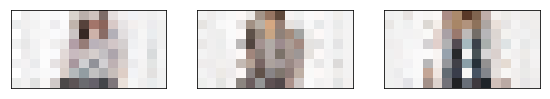

In [25]:
for X_batch, y_batch in train_loader:
    break
mask_first_part = np.zeros((batch_size, 3, int(dim_x / 2), dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(int(dim_x/2)):
            for j in range(dim_x):
                if j % 2 == 0:
                    mask_first_part[m][n][i][j] = True
mask_second_part = np.zeros((batch_size, 3, int(dim_x / 2), dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(int(dim_x/2)):
            for j in range(dim_x):
                if j % 2 == 1:
                    mask_second_part[m][n][i][j] = True

X_batch_input = X_batch[:, 0]
X_batch_input = X_batch_input[mask_input_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))
y_batch_output = y_batch[:, 1]
y_batch_output = y_batch_output[mask_input_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))

X_batch_input = Variable(convert_input_into_image_4(X_batch_input, y_batch_output)).cuda()
X_batch_group_2 = net8_group2(X_batch_input,
     keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
     embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1])
#             print(X_batch_input.shape)
#             print(X_batch_group_2.shape)
X_cur_input = Variable(torch.zeros((batch_size, 3, int(dim_x / 2), int(dim_x)))).cuda().float()
X_cur_input[mask_first_part.nonzero()] = X_batch_input.view(-1).float()
X_cur_input[mask_second_part.nonzero()] = X_batch_group_2.view(-1).float()
plot_gallery(X_cur_input.cpu().data, 8, 8, 1, 3)

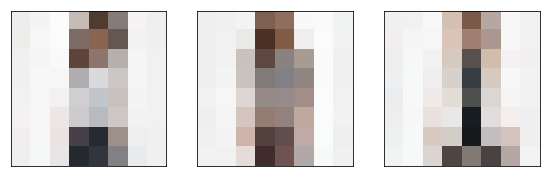

In [28]:
plot_gallery(net8_group3(X_cur_input,
                 keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1]).cpu().data,
             8, 8, 1, 3)

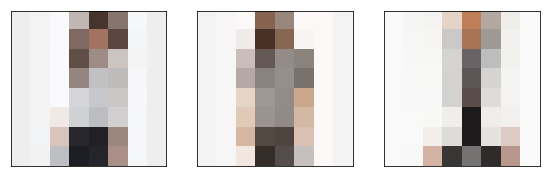

In [30]:
X_batch_output = X_batch[:, 1]
X_batch_output = X_batch_output[mask_output_2.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))
plot_gallery(X_batch_output, 8, 8, 1, 3)

In [32]:
mask8_group_1 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 == 0:
                    mask8_group_1[m][n][i][j] = True
mask8_group_2 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 == 1:
                    mask8_group_2[m][n][i][j] = True

mask8_group_3 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 0:
                    mask8_group_3[m][n][i][j] = True

In [86]:
def train_group4_network(net, criterion, optimizer, mask_input, mask_output, shape_output, num_epochs):
    train_loss = []
    val_loss = []
    
    mask_first_part = np.zeros((batch_size, 3, int(dim_x / 2), dim_x)).astype(bool)
    for m in range(batch_size):
        for n in range(3):
            for i in range(int(dim_x/2)):
                for j in range(dim_x):
                    if j % 2 == 0:
                        mask_first_part[m][n][i][j] = True
    mask_second_part = np.zeros((batch_size, 3, int(dim_x / 2), dim_x)).astype(bool)
    for m in range(batch_size):
        for n in range(3):
            for i in range(int(dim_x/2)):
                for j in range(dim_x):
                    if j % 2 == 1:
                        mask_second_part[m][n][i][j] = True
    
    for epoch in range(num_epochs):
        start_time = time.time()
        net.train(True)
        i = 0
        for X_batch, y_batch in train_loader:
            i += 1
            if X_batch.shape[0] != batch_size:
                continue
#             X_batch_input = X_batch[:, 0]
#             X_batch_input[(~mask_input).nonzero()] = 0
#             X_batch_input = Variable(X_batch_input).cuda()

#             X_batch_output = X_batch[:, 1]
#             X_batch_output = X_batch_output[mask_output.nonzero()].view(shape_output)
#             X_batch_output = Variable(X_batch_output).cuda()

            X_batch_input = X_batch[:, 0]
            X_batch_input = X_batch_input[mask_input.nonzero()].view(shape_output)
            
            y_batch_output = y_batch[:, 1]
            y_batch_output = y_batch_output[mask_input.nonzero()].view(shape_output)
            
            X_batch_input = Variable(convert_input_into_image_4(X_batch_input, y_batch_output)).cuda()
            X_batch_group_2 = net8_group2(X_batch_input,
                 keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1])
#             print(X_batch_input.shape)
            X_cur_input = Variable(torch.zeros((batch_size, 3, int(dim_x / 2), dim_x))).cuda().float()
            X_cur_input[mask_first_part.nonzero()] = X_batch_input.view(-1).float()
            X_cur_input[mask_second_part.nonzero()] = X_batch_group_2.view(-1).float()
            X_batch_group_3 = net8_group3(X_cur_input,
                 keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1])
#             print(X_cur_input.shape)

            X_cur_input = Variable(torch.zeros((batch_size, 3, dim_x, dim_x))).cuda().float()
            X_cur_input[mask8_group_1.nonzero()] = X_batch_input.view(-1).float()
            X_cur_input[mask8_group_2.nonzero()] = X_batch_group_2.view(-1).float()
            X_cur_input[mask8_group_3.nonzero()] = X_batch_group_3.view(-1).float()
    
            X_batch_output = X_batch[:, 1]
            X_batch_output = X_batch_output[mask_output.nonzero()].view(shape_output)
            X_batch_output = Variable(X_batch_output).cuda()

            output_img = net(X_cur_input,
                             keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                             embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1])
            loss = criterion(output_img, X_batch_output)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.cpu().data.numpy()[0])

        # And a full pass over the validation data:
    #     autoencoder.train(False) # disable dropout / use averages for batch_norm
    #     for X_batch, y_batch in val_loader:
    #         X_batch_0 = Variable(y_batch[:, 0]).cuda()
    #         output_img, _ = autoencoder(X_batch_0)
    #         val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
    #         X_batch_1 = Variable(y_batch[:, 1]).cuda()
    #         output_img, _ = autoencoder(X_batch_1)
    #         val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])

        print 
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-2 * len(train_loader):])))
    #     print("  validation loss: \t\t\t{:.6f}".format(
    #         np.mean(val_loss[-2 * len(val_loader):])))

In [87]:
class Net8Group4(nn.Module):
    """
        Network for predictions group 2 images based on group 1.
        input size: 4x4
        output size: 4x4
    """

    def __init__(self, layers=[1], bottelneck_size=32):
        super(Net8Group4, self).__init__()
        
        self.first_part = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
#             nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(96, 64, 2, stride=2)
        )

        self.conv_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), padding=1),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=(2, 2), stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, keypoints, embeddings):
        x = self.first_part(x)
        x = torch.cat((x, keypoints, embeddings), dim=1)
        x = self.up_1(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        return x

In [62]:
# mask_input_3 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
# for m in range(batch_size):
#     for n in range(3):
#         for i in range(dim_x):
#             for j in range(dim_x):
#                 if i % 2 == 0 or j % 2 == 0:
#                     mask_input_3[m][n][i][j] = True

In [88]:
mask_output_3 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 1:
                    mask_output_3[m][n][i][j] = True

In [ ]:
criterion = torch.nn.MSELoss()
net8_group4 = Net8Group4().cuda()
optimizer = optim.Adam(net8_group4.parameters(), lr=1e-3)

In [ ]:
train_group4_network(net8_group4, criterion, optimizer, mask_input_1, mask_output_3,
#                      shape_input=(batch_size, 3, dim_x, dim_x),
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=100
             )

Epoch 1 of 100 took 54.448s
  training loss (in-iteration): 	0.017257
Epoch 2 of 100 took 53.941s
  training loss (in-iteration): 	0.011796
Epoch 3 of 100 took 55.410s
  training loss (in-iteration): 	0.005985
Epoch 4 of 100 took 53.873s
  training loss (in-iteration): 	0.005445
Epoch 5 of 100 took 54.621s
  training loss (in-iteration): 	0.005154
Epoch 6 of 100 took 53.112s
  training loss (in-iteration): 	0.004966
Epoch 7 of 100 took 53.553s
  training loss (in-iteration): 	0.004834
Epoch 8 of 100 took 54.650s
  training loss (in-iteration): 	0.004739
Epoch 9 of 100 took 54.624s
  training loss (in-iteration): 	0.004653
Epoch 10 of 100 took 53.418s
  training loss (in-iteration): 	0.004558
Epoch 11 of 100 took 55.628s
  training loss (in-iteration): 	0.004470
Epoch 12 of 100 took 54.433s
  training loss (in-iteration): 	0.004396
Epoch 13 of 100 took 58.203s
  training loss (in-iteration): 	0.004337
Epoch 14 of 100 took 77.587s
  training loss (in-iteration): 	0.004286
Epoch 15 of 100

In [104]:
train_group4_network(net8_group4, criterion, optimizer, mask_input_1, mask_output_3,
#                      shape_input=(batch_size, 3, dim_x, dim_x),
              shape_output=(batch_size, 3, int(dim_x / 2), int(dim_x / 2)),
              num_epochs=1
             )

Epoch 1 of 1 took 51.362s
  training loss (in-iteration): 	0.002350


In [ ]:
print("hi")

In [92]:
torch.save(net8_group4, "net8.group4.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net8Group4. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


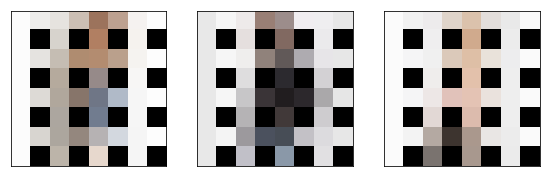

In [347]:
X_batch_input = X_batch[:, 0].clone()
X_batch_input[(~mask_input_3).nonzero()] = 0
X_batch_input = Variable(X_batch_input).cuda()
plot_gallery(X_batch_input.cpu().data, 8, 8, 1, 3)

In [93]:
mask_group_1 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 == 0:
                    mask_group_1[m][n][i][j] = True

mask_group_2 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 0 and j % 2 == 1:
                    mask_group_2[m][n][i][j] = True

mask_group_3 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 0:
                    mask_group_3[m][n][i][j] = True

mask_group_4 = np.zeros((batch_size, 3, dim_x, dim_x)).astype(bool)
for m in range(batch_size):
    for n in range(3):
        for i in range(dim_x):
            for j in range(dim_x):
                if i % 2 == 1 and j % 2 == 1:
                    mask_group_4[m][n][i][j] = True

In [119]:
def convert_input_into_image_8(X_batch):
    X_batch_input = X_batch[:, 0].clone()
    X_batch_input = X_batch_input[mask_input_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))

    y_batch_output = y_batch[:, 1].clone()
    y_batch_output = y_batch_output[mask_input_1.nonzero()].view((batch_size, 3, int(dim_x / 2), int(dim_x / 2)))

    X_batch_input = Variable(convert_input_into_image_4(X_batch_input, y_batch_output)).cuda()
    
    group_1 = X_batch_input.cpu().data
    
    group_2 = net8_group2(X_batch_input,
                 keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                 embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1]).cpu().data
    
    X_cur_input = torch.zeros((batch_size, 3, int(dim_x / 2), dim_x)).float()
    X_cur_input[mask_first_part.nonzero()] = group_1.view(-1).float()
    X_cur_input[mask_second_part.nonzero()] = group_2.view(-1).float()
    group_3 = net8_group3(Variable(X_cur_input).cuda(),
             keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
             embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1]).cpu().data
    
    X_cur_input = torch.zeros((batch_size, 3, dim_x, dim_x)).float()
    X_cur_input[mask8_group_1.nonzero()] = group_1.view(-1).float()
    X_cur_input[mask8_group_2.nonzero()] = group_2.view(-1).float()
    X_cur_input[mask8_group_3.nonzero()] = group_3.view(-1).float()
    
    group_4 = net8_group4(Variable(X_cur_input).cuda(),
                         keypoints=autoencoder_stickmans_8(Variable(y_batch[:, 1]).cuda())[1],
                         embeddings=autoencoder_people_8(Variable(X_batch[:, 0]).cuda())[1]).cpu().data
    
    final_image = torch.zeros_like(X_batch[:, 1]).float()
    final_image[mask_group_1.nonzero()] = group_1.view(-1).float()
    final_image[mask_output_1.nonzero()] = group_2.view(-1).float()
    final_image[mask_output_2.nonzero()] = group_3.view(-1).float()
    final_image[mask_output_3.nonzero()] = group_4.view(-1).float()
    
    plot_gallery(X_batch[:, 0], 8, 8, 1, 3)
    plot_gallery(X_batch[:, 1], 8, 8, 1, 3)
    plot_gallery(final_image, 8, 8, 1, 3)

In [127]:
for i, (X_batch, y_batch) in enumerate(train_loader):
    if i == 15:
        break

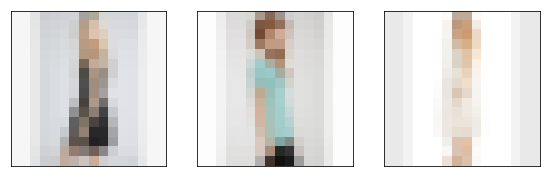

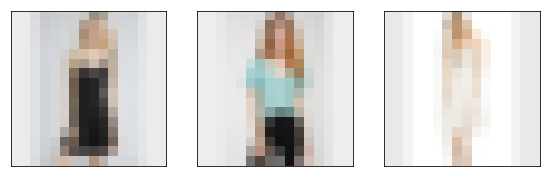

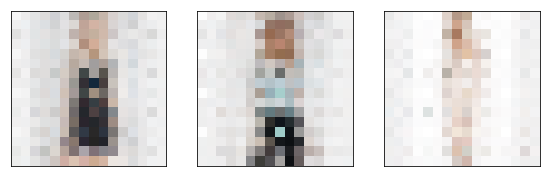

In [128]:
convert_input_into_image_8(X_batch)